<a href="https://colab.research.google.com/github/hayannn/AIFFEL_STUDY/blob/main/%EC%BA%90%EA%B8%80_%EC%82%B0%ED%83%84%EB%8D%B0%EB%A5%B4_%EA%B3%A0%EA%B0%9D_%EB%A7%8C%EC%A1%B1_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. 캐글 데이터 불러오기

- 캐글 계정 권한 확인

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hayannnlee","key":"3a782aa2ecd254bea8d9a8f70f8bf5cf"}'}

In [4]:
ls -1ha kaggle.json

kaggle.json


In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

- API 가져와 파일 다운로드

In [6]:
!kaggle competitions download -c santander-customer-satisfaction

 61% 5.00M/8.25M [00:00<00:00, 40.3MB/s]
100% 8.25M/8.25M [00:00<00:00, 60.3MB/s]


In [7]:
!ls

kaggle.json  sample_data  santander-customer-satisfaction.zip


- 압축 해제

In [8]:
!unzip -qq '/content/santander-customer-satisfaction.zip' -d '/content/'

In [9]:
!ls

kaggle.json  sample_submission.csv		  test.csv
sample_data  santander-customer-satisfaction.zip  train.csv


- 파일명 변경

In [10]:
import os

# 원본 파일
o_file = "/content/train.csv"

# 새 파일
n_file = "/content/train_santander.csv"

os.rename(o_file, n_file)

In [11]:
!ls

kaggle.json  sample_submission.csv		  test.csv
sample_data  santander-customer-satisfaction.zip  train_santander.csv


- 구글 드라이브에 원본 데이터 업로드(세션 중지로 인해 데이터 유실 우려)

In [18]:
from google.colab import drive
import shutil

colab_path = '/content/train_santander.csv'
copy_path = '/content/drive/MyDrive/Colab Notebooks/1111분류실습_캐글산탄데르고객만족예측/train_santander.csv'

shutil.copy(colab_path, copy_path)

'/content/drive/MyDrive/Colab Notebooks/1111분류실습_캐글산탄데르고객만족예측/train_santander.csv'

# 1. 데이터 전처리
### 모듈 가져오기 & 데이터 불러오기
- XGBoost는 사이킷런 래퍼 이용
- 필요 모듈 로딩 및 학습 데이터 DataFrame으로 로딩
  - numpy, pandas, matplotlib, warnings

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings

warnings.filterwarnings('ignore')
cust_df = pd.read_csv("/content/train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


### 피쳐 타입 및 Null 값 확인
- folat형 데이터 111개
- int형 데이터 260개
- Null 값 없음

In [20]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


### 전체 데이터 중 만족 및 불만족 비율 살펴보기
- Target 속성값 분포 확인
  - 대부분 만족, 불만족 고객은 4%에 불과

In [22]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 비율은 0.04


### 각 피쳐값 분포 확인
- var3의 min 값이 -999999
  - NaN 또는 특정 예외 값을 -999999로 변환했을 것

In [23]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


- -999999는 총 116개 존재

In [24]:
cust_df['var3'].value_counts()

,count
var3,
2,74165
8,138
-999999,116
9,110
3,108
...,...
231,1
188,1
168,1


### 최빈값으로 대체하기 & 피쳐 정리
- var3는 숫자형, -999999는 다른 값에 비해 편차가 심하니, 최빈값인 2로 변경
- ID : 단순 식별자이기 때문에 Drop
- 클래스 데이터 세트 및 피쳐 데이터 세트 분리 -> 별도의 데이터 세트로 별도 저장
  - 레이블 컬럼은 DataFrame의 맨 마지막에 위치헤 컬럼 위치를-1로 분리

In [25]:
cust_df['var3'].replace(-999999, 2, inplace=True)

cust_df.drop('ID', axis=1, inplace=True)

X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


### 학습 데이터 세트와 테스트 데이터 세트 분리
- 비대칭 데이터 세트이므로 클래스인 Target 값 분포도가 학습 데이터 및 데이터 데이트 세트에 유사하게 추출되었는지 확인

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

 테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


- 데이터 세트 모두 TARGET 값 분포가 원본 데이터와 유사하게 만들어짐
  - 전체 데이터의 4%정도의 불만족 값(값 1)로 만들어짐

<br>

# 2. XGBoost 모델 학습과 하이퍼 파라미터 튜닝
- XGBoost 학습 모델 생성
- 예측 결과를 ROC AUC로 평가
- 성능 평가 기준이 ROC AUC이므로, XGBClassifier의 eval_metric은 'auc'로 설정
- 학습 및 검증 데이터 세트를 이용해 eval_set 설정
- 조기 중단은 100회로 설정한 뒤 학습 진행
- 테스트 데이터 세트로 평가된 ROC-AUC 값 확인

In [29]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

> #### early_stopping_rounds TypeError 해결
![image](https://github.com/user-attachments/assets/13388f80-9c46-4d41-a4ed-6df99ffa66ec)
  - 데이터 학습 이전 xgb_clf 함수에 early_stopping_rounds와 eval_metric을 삽입

  - 이전
  ```python
  xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=156)

  xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_tr, y_tr), (X_val, y_val)])
  ...
  ```

  - 이후
  ```python
  xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=156, early_stopping_rounds=100, eval_metric='auc')

  xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)])
  ...
  ```

In [45]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=156, early_stopping_rounds=100, eval_metric='auc')

xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.83603	validation_1-auc:0.80978
[1]	validation_0-auc:0.83783	validation_1-auc:0.81126
[2]	validation_0-auc:0.83892	validation_1-auc:0.81192
[3]	validation_0-auc:0.84090	validation_1-auc:0.81349
[4]	validation_0-auc:0.84187	validation_1-auc:0.81356
[5]	validation_0-auc:0.84355	validation_1-auc:0.81422
[6]	validation_0-auc:0.84534	validation_1-auc:0.81550
[7]	validation_0-auc:0.84658	validation_1-auc:0.81623
[8]	validation_0-auc:0.84727	validation_1-auc:0.81669
[9]	validation_0-auc:0.84794	validation_1-auc:0.81668
[10]	validation_0-auc:0.84980	validation_1-auc:0.81828
[11]	validation_0-auc:0.85105	validation_1-auc:0.81965
[12]	validation_0-auc:0.85217	validation_1-auc:0.81999
[13]	validation_0-auc:0.85301	validation_1-auc:0.82049
[14]	validation_0-auc:0.85558	validation_1-auc:0.82210
[15]	validation_0-auc:0.85662	validation_1-auc:0.82288
[16]	validation_0-auc:0.85811	validation_1-auc:0.82380
[17]	validation_0-auc:0.85864	validation_1-auc:0.82365
[18]	validation_0-au

### HyperOpt를 이용한 베이지안 최적화 기반으로 XGBoost 하이퍼 파라미터 튜닝
- 하이퍼 파라미터 검색 공간 설정
  - max_depth : 5에서 15까지 1간격
  - min_child_weight : 1에서 6까지 1간격
  - colsample_bytree : 0.5에서 0.95사이
  - learning_rate : 0.01에서 0.2사이 정규 분포된 값

In [49]:
from hyperopt import hp

xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 15, 1),
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
}

- 목적함수
  - 3 Fold 교차 검증으로 평균 ROC-AUC 값을 반환
    - -1을 곱해 최대 ROC-AUC 값이 최소 반환값이 되도록 설정
  - KFold 클래스로 학습과 검증 데이터 세트 추출 및 교차 검증 횟수만큼의 학습과 성능 평가 수행

> 이 부분에서도 early_stoppin_rounds 및 eval_metric을 XGBClassfier 선언지점으로 이동

In [55]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# 목적 함수
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            colsample_bytree=search_space['colsample_bytree'],
                            learning_rate=search_space['learning_rate'],
                            early_stopping_rounds=30,
                            eval_metric='auc'
                           )
    roc_auc_list= []

    kf = KFold(n_splits=3)

    # X_train : 학습용 데이터, 검증용 데이터 분리
    for tr_index, val_index in kf.split(X_train):
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        xgb_clf.fit(X_tr, y_tr,
                   eval_set=[(X_tr, y_tr), (X_val, y_val)])

        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)

    return -1 * np.mean(roc_auc_list)

- fmin() 함수 호출로 max_eval=50회마큼 반복해 최적 하이퍼 파라미터 도출

In [56]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[65]	validation_0-auc:0.92527	validation_1-auc:0.83087
[66]	validation_0-auc:0.92541	validation_1-auc:0.83076
[67]	validation_0-auc:0.92558	validation_1-auc:0.83075
[68]	validation_0-auc:0.92561	validation_1-auc:0.83064
[69]	validation_0-auc:0.92588	validation_1-auc:0.83060
[70]	validation_0-auc:0.92633	validation_1-auc:0.83030
[71]	validation_0-auc:0.92674	validation_1-auc:0.83008
[72]	validation_0-auc:0.92674	validation_1-auc:0.83019
[73]	validation_0-auc:0.92697	validation_1-auc:0.83000
[0]	validation_0-auc:0.79699	validation_1-auc:0.75771
[1]	validation_0-auc:0.80823	validation_1-auc:0.75852
[2]	validation_0-auc:0.85488	validation_1-auc:0.80177
[3]	validation_0-auc:0.86613	validation_1-auc:0.81605
[4]	validation_0-auc:0.87207	validation_1-auc:0.81836
[5]	validation_0-auc:0.87502	validation_1-auc:0.82251
[6]	validation_0-auc:0.87455	validation_1-auc:0.82088
[7]	validation_0-auc:0.87866	validation_1-auc:0.82335
[8]	validation_0-auc:0.87925	validati

- 결과
 - colsample_bytree : 0.6643830351565323
 - learning_rate': 0.12059317842651635
 - max_depth': 5.0
 - min_child_weight': 6.0
<br>

### 도출된 최적 하이퍼 파라미터 기반 XGBClassifier 재학습 및 테스트 데이터 세트에서의 ROC AUC 측정
- n_estimators는 500으로 증가
- evaluation metric는 auc, early stopping은 100으로 설정

In [57]:
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=round(best['learning_rate'], 5),
                        max_depth=int(best['max_depth']), min_child_weight=int(best['min_child_weight']),
                        colsample_bytree=round(best['colsample_bytree'], 5),
                        early_stopping_rounds=100,
                        eval_metric="auc"
                       )

xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.75617	validation_1-auc:0.72424
[1]	validation_0-auc:0.76951	validation_1-auc:0.74072
[2]	validation_0-auc:0.82130	validation_1-auc:0.80125
[3]	validation_0-auc:0.83279	validation_1-auc:0.81455
[4]	validation_0-auc:0.83956	validation_1-auc:0.81850
[5]	validation_0-auc:0.84333	validation_1-auc:0.82213
[6]	validation_0-auc:0.84084	validation_1-auc:0.81983
[7]	validation_0-auc:0.84478	validation_1-auc:0.82208
[8]	validation_0-auc:0.84368	validation_1-auc:0.82108
[9]	validation_0-auc:0.83998	validation_1-auc:0.81681
[10]	validation_0-auc:0.84522	validation_1-auc:0.82318
[11]	validation_0-auc:0.84725	validation_1-auc:0.82612
[12]	validation_0-auc:0.84671	validation_1-auc:0.82558
[13]	validation_0-auc:0.84554	validation_1-auc:0.82439
[14]	validation_0-auc:0.84456	validation_1-auc:0.82284
[15]	validation_0-auc:0.84872	validation_1-auc:0.82748
[16]	validation_0-auc:0.85139	validation_1-auc:0.82836
[17]	validation_0-auc:0.85154	validation_1-auc:0.82826
[18]	validation_0-au

- 하이퍼 파라미터 튜닝 이전 수치보다 증가
  - ROC AUC : 0.8417 -> 0.8456

### 튜닝된 모델의 각 피쳐 중요도 그래프 그리기

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

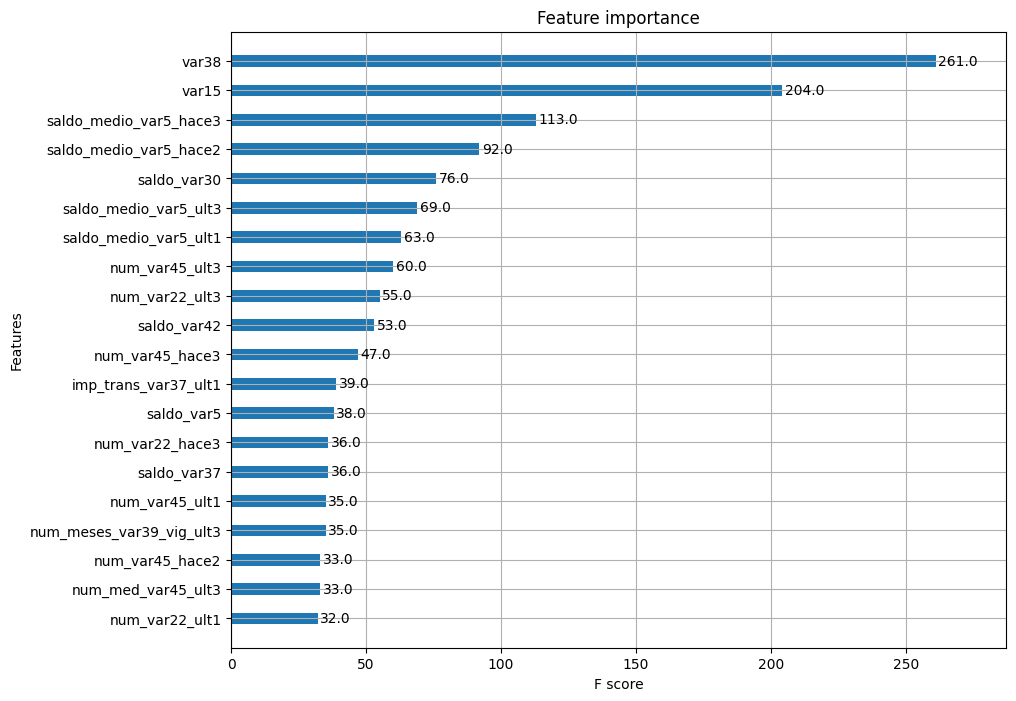

In [58]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax , max_num_features=20,height=0.4)

# 3. LightGBM 모델 학습과 하이퍼 파라미터 튜닝
- 동일한 값을 주고, ROC-AUC 값 확인

In [63]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500, early_stopping_rounds=100, eval_metric="auc")

eval_set=[(X_tr, y_tr), (X_val, y_val)]
lgbm_clf.fit(X_tr, y_tr, eval_set=eval_set)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13308
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 242
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training un

### HyperOpt로 하이퍼 파라미터 튜닝 수행
- 튜닝 대상 : num_leaves, max_depth, min_child_samples, subsample, learning_rate

In [64]:
# 검색 공간 설정
lgbm_search_space = {'num_leaves': hp.quniform('num_leaves', 32, 64, 1),
                     'max_depth': hp.quniform('max_depth', 100, 160, 1),
                     'min_child_samples': hp.quniform('min_child_samples', 60, 100, 1),
                     'subsample': hp.uniform('subsample', 0.7, 1),
                     'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
                    }

- 목적 함수 생성

In [65]:
def objective_func(search_space):
    lgbm_clf =  LGBMClassifier(n_estimators=100, num_leaves=int(search_space['num_leaves']),
                               max_depth=int(search_space['max_depth']),
                               min_child_samples=int(search_space['min_child_samples']),
                               subsample=search_space['subsample'],
                               learning_rate=search_space['learning_rate'],
                               early_stopping_rounds=30,
                               eval_metric="auc"
                               )
    roc_auc_list = []

    kf = KFold(n_splits=3)

    for tr_index, val_index in kf.split(X_train):

        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

        lgbm_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)])
        score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)

    return -1*np.mean(roc_auc_list)

- fmin() 호출로 최적 하이퍼 파라미터 도출

In [66]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

best = fmin(fn=objective_func, space=lgbm_search_space, algo=tpe.suggest,
            max_evals=50, trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1579, number of negative: 38965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12827
[LightGBM] [Info] Number of data points in the train set: 40544, number of used features: 192
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038945 -> initscore=-3.205872
[LightGBM] [Info] Start training from score -3.205872
Training until va

- learning_rate : 0.07283348800335702
- max_depth : 133.0
- min_child_samples : 89.0
- num_leaves : 32.0
- subsample : 0.7011491391896255

<br>

### 하이퍼 파라미터를 이용한 LightGBM 학습 및 테스트 데이터 세트에서 ROC-AUC 평가

In [67]:
lgbm_clf =  LGBMClassifier(n_estimators=500, num_leaves=int(best['num_leaves']),
                           max_depth=int(best['max_depth']),
                           min_child_samples=int(best['min_child_samples']),
                           subsample=round(best['subsample'], 5),
                           learning_rate=round(best['learning_rate'], 5),
                           early_stopping_rounds=100,
                           eval_metric="auc"
                          )

lgbm_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)])

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.116760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12898
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 192
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training un

- ROC AUC: 0.8384 -> 0.8403

# 개인적 견해
- XGBoost와 LightGBM을 이용한 모델 학습 및 하이퍼 파라미터 튜닝 과정
  - XGBoost의 경우, 구글 코랩 기준 약 45분이 소요되었음
  - 다른 팀원의 경우, LMS의 클라우드 주피터를 이용했으며 약 2시간 30분 가량이 소요되었다는 이야기를 듣게 됨
    - XGBoost는 LightGBM보다 소요 시간 자체가 긴 단점이 있음
    - 그렇기 때문에 교재에서도 "일반 PC가 아닌 적어도 8코어 이상의 병렬 CPU 코어 시스템을 가진 컴퓨터가 있다면" 파라미터 조절이 더 자유로워질 것이라는 언급이 있음!

    - 그래도, LightGBM보다 더 세밀한 옵션 조정이 가능하고 견고한 성능을 제공한다는 특징이 있음
    - 이렇게 다양한 ML 알고리즘을 학습하는 입장에서는 XGBoost의 용이한 사용에는 제약이 있을 것으로 생각됨

> 결론 : 추후 프로젝트 진행 시에 XGBoost와 같은 알고리즘 도입에 있어 신중한 판단이 필요할 것이다!